# Aplicación de SVM NO lineal

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2025

**Versión:** 1.1  

**Fecha de Creación:** Enero de 2025

**Versión:** 1.0  

---

## Descripción

Este notebook contiene la explicación de Support Vector Machine (SVM) NO lineal para un problema de clasificación.

Utiliza un kernel RBF y trabaja con datos artificiales.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.12. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

from typing import Union
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, silhouette_score

In [2]:
# Generar datos artificiales con ruido
X, y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=0.8, flip_y=0.1, random_state=29
)

✅ **Importante**

+ `flip_y=0.1`: alrededor del 10% de las etiquetas están asignadas aleatoriamente, por lo tanto, no puede existir un hiperplano (una línea en 2D) que separe perfectamente ambas clases.

+ `class_sep=0.8` hace que las clases estén relativamente juntas, lo que aumenta la posibilidad de intersección entre clases.

In [3]:
silhouette_avg = silhouette_score(X, y)
print(f"Índice de Silhouette: {silhouette_avg : .4f}")

Índice de Silhouette:  0.2652


![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTwXfP05PZP6sO4qotRvxvDpC8o6NNiwLStAw&s)

In [4]:
# Revisión de la distribuciñon de la variable objetivo
y_series = pd.Series(y)
print(y_series.value_counts())

1    258
0    242
Name: count, dtype: int64


In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29, stratify=y)

# Crear un modelo SVM NO lineal
svm_no_lineal = SVC(kernel='rbf', C=1, gamma=1, probability=True, random_state=29)
svm_no_lineal.fit(X_train, y_train)

# Predicciones
y_pred = svm_no_lineal.predict(X_test)

# Evaluar el modelo
print("Reporte de clasificación (SVM NO lineal):")
print(classification_report(y_test, y_pred))

Reporte de clasificación (SVM NO lineal):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        48
           1       0.92      0.94      0.93        52

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [39]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:\n", cm)


Matriz de Confusión:
 [[47  1]
 [ 9 43]]


In [7]:
# Graficar los datos y la frontera de decisión
def plot_decision_boundary(X : np.array, y : Union[np.ndarray, list],
                           model : BaseEstimator, title : str) -> None:
  """
    Dibuja la frontera de decisión de un modelo clasificador en un conjunto de datos bidimensional.

    Parámetros:
    - X (np.ndarray): Matriz de características de tamaño (n_samples, n_features), donde n_features = 2.
    - y (Union[np.ndarray, list]): Etiquetas correspondientes a los datos X.
    - model (BaseEstimator): Modelo de scikit-learn ajustado que implementa el método predict.
    - title (str): Título para el gráfico.

    Retorno:
    - None: La función muestra el gráfico pero no retorna ningún valor.
  """
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
  )
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
  plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
  plt.title(title, fontsize=15, fontweight="bold")
  plt.show()

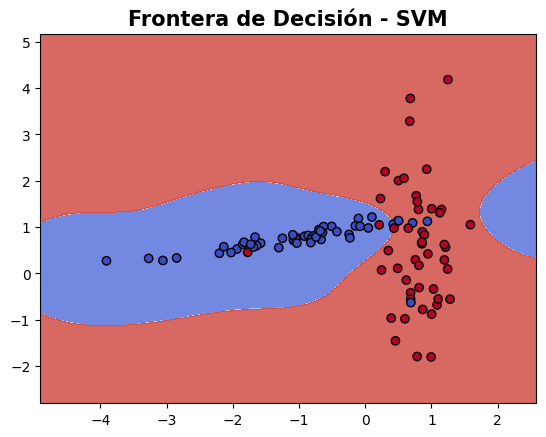

In [8]:
# Gráfica de la frontera de decisión
plot_decision_boundary(X_test, y_test, svm_no_lineal, "Frontera de Decisión - SVM")

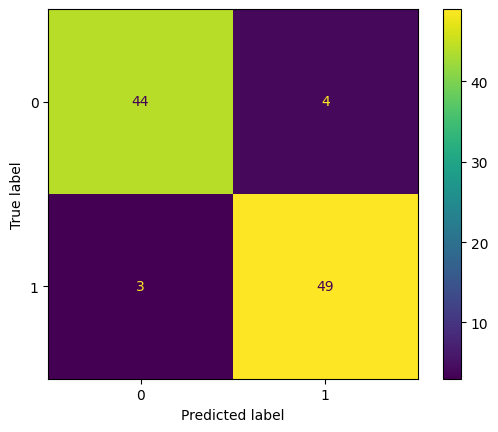

In [9]:
# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Experimentación

**🧠 Ahora se van a generar experimientos paa ver la evolución de la frontera de decisión**

In [10]:
def experimento(X_train : np.array, X_test : np.array, y_train : np.array, y_test : np.array,
                C_value : float, gamma_value : float):
  """
  Genera un modelo SVM NO lineal y devuelve predicciones y accuracy.

  Parámetros:
  - X_train (np.array): Conjunto de características de entrenamiento.
  - X_test (np.array): Conjunto de características de prueba.
  - y_train (np.array): Etiquetas correspondientes a X_train.
  - y_test (np.array): Etiquetas correspondientes a X_test.
  - C_value (float): Parámetro de regularización C del modelo SVM.
  - gamma_value (float): Parámetro gamma del modelo SVM.

  Retorno:
  - modelo (SVC): Modelo SVM NO lineal ajustado.
  - y_pred (np.array): Predicciones del modelo en el conjunto de prueba.
  - accuracy (float): Accuracy del modelo en el conjunto de prueba.
  """
  # Crear un modelo SVM NO lineal
  modelo = SVC(kernel='rbf', C=C_value, gamma=gamma_value, probability=True, random_state=29)
  modelo.fit(X_train, y_train)

  # Retorna predicciones y accuracy
  y_pred = modelo.predict(X_test)
  return modelo, y_pred, accuracy_score(y_test, y_pred)

In [22]:
def ver_resultados(resultados : dict, C_value : float) -> None:
  """
  Genera gráfico de evolución de accuracy en los experimentos

  Parámetros:
  - resultados (dict): Diccionario con resultados de experimentos.
  - C_value (float): Parámetro de regularización C del modelo SVM.

  Retorno:
  - None: La función muestra el gráfico pero no retorna ningún valor.
  """
  # Separar claves y valores
  gammas = list(resultados.keys())
  accuracy = list(resultados.values())

  # Crear el gráfico
  plt.figure(figsize=(8,5))
  plt.plot(gammas, accuracy, marker='o', linestyle='-', color='blue')
  plt.xscale('log')  # escala logarítmica para gamma, para poder apreciar los valores
  plt.xlabel('Valor de gamma', fontsize=14, fontweight="bold")
  plt.ylabel('Accuracy', fontsize=14, fontweight="bold")
  plt.title(f'Evolución del Accuracy según gamma\nSVM No Lineal con C = {C_value}', fontsize=16, fontweight="bold")
  plt.grid(True)
  plt.show()

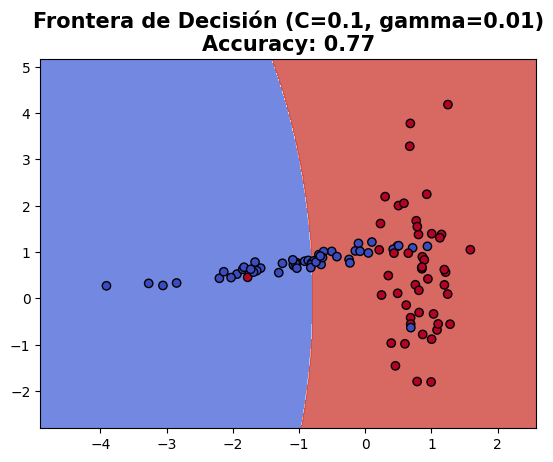

Reporte de clasificación (SVM NO lineal):
              precision    recall  f1-score   support

           0       0.93      0.56      0.70        48
           1       0.70      0.96      0.81        52

    accuracy                           0.77       100
   macro avg       0.82      0.76      0.76       100
weighted avg       0.81      0.77      0.76       100



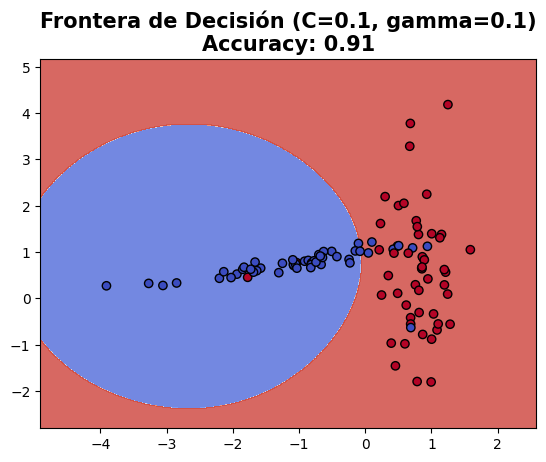

Reporte de clasificación (SVM NO lineal):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        48
           1       0.88      0.96      0.92        52

    accuracy                           0.91       100
   macro avg       0.92      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



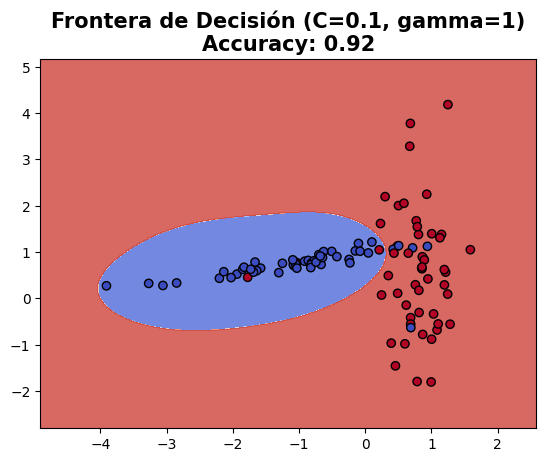

Reporte de clasificación (SVM NO lineal):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        48
           1       0.91      0.94      0.92        52

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



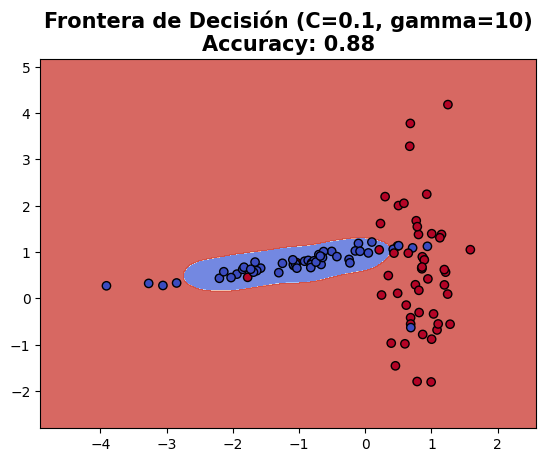

Reporte de clasificación (SVM NO lineal):
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        48
           1       0.84      0.94      0.89        52

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



In [23]:
C_value = 0.1
resultados = {}
for gamma_value in [0.01, 0.1, 1, 10]:
  modelo, y_pred, accuracy = experimento(X_train, X_test, y_train, y_test, C_value, gamma_value)
  # Gráfica de la frontera de decisión
  plot_decision_boundary(X_test, y_test, modelo,
                         f"Frontera de Decisión (C={C_value}, gamma={gamma_value})\nAccuracy: {accuracy}")

  print("Reporte de clasificación (SVM NO lineal):")
  print(classification_report(y_test, y_pred))
  resultados[gamma_value] = accuracy

In [24]:
resultados

{0.01: 0.77, 0.1: 0.91, 1: 0.92, 10: 0.88}

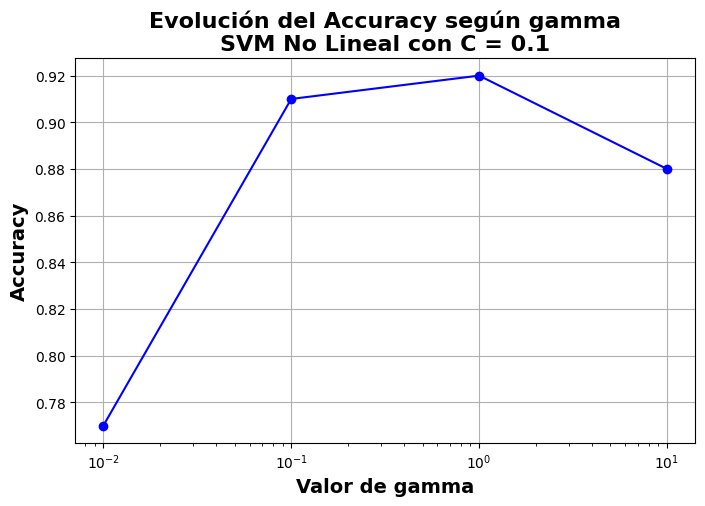

In [25]:
ver_resultados(resultados, C_value)


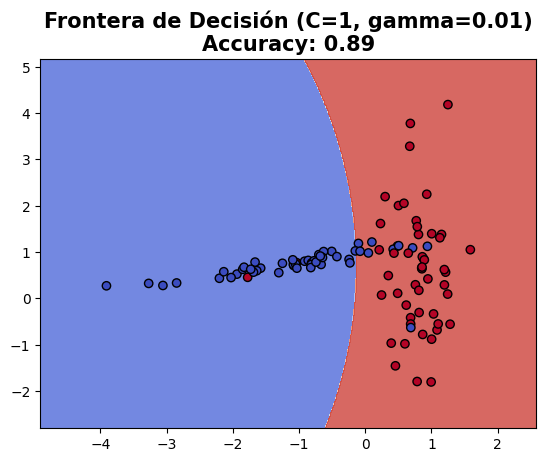

Reporte de clasificación (SVM NO lineal) C=1, gamma=0.01
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        48
           1       0.85      0.96      0.90        52

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100



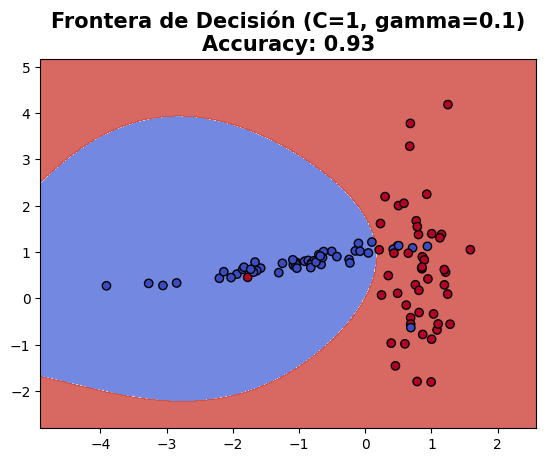

Reporte de clasificación (SVM NO lineal) C=1, gamma=0.1
              precision    recall  f1-score   support

           0       0.96      0.90      0.92        48
           1       0.91      0.96      0.93        52

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



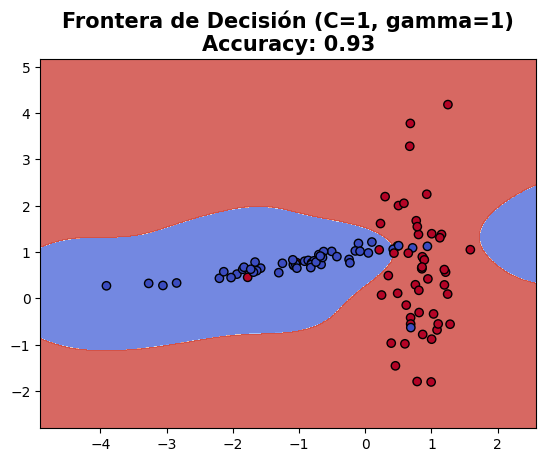

Reporte de clasificación (SVM NO lineal) C=1, gamma=1
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        48
           1       0.92      0.94      0.93        52

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



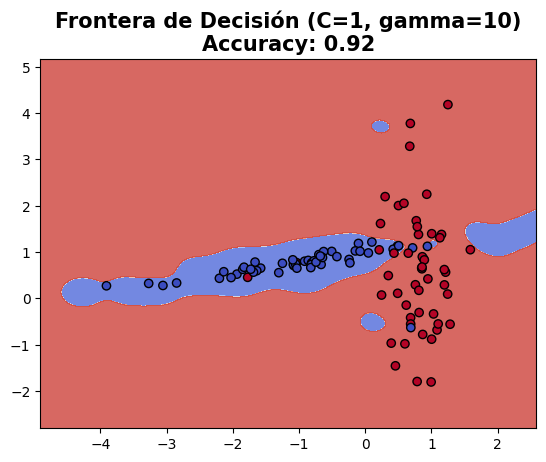

Reporte de clasificación (SVM NO lineal) C=1, gamma=10
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        48
           1       0.94      0.90      0.92        52

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [26]:
C_value = 1
resultados_c1 = {}
for gamma_value in [0.01, 0.1, 1, 10]:
  modelo, y_pred, accuracy = experimento(X_train, X_test, y_train, y_test, C_value, gamma_value)
  # Gráfica de la frontera de decisión
  plot_decision_boundary(X_test, y_test, modelo,
                         f"Frontera de Decisión (C={C_value}, gamma={gamma_value})\nAccuracy: {accuracy}")

  print(f"Reporte de clasificación (SVM NO lineal) C={C_value}, gamma={gamma_value}")
  print(classification_report(y_test, y_pred))
  resultados_c1[gamma_value] = accuracy

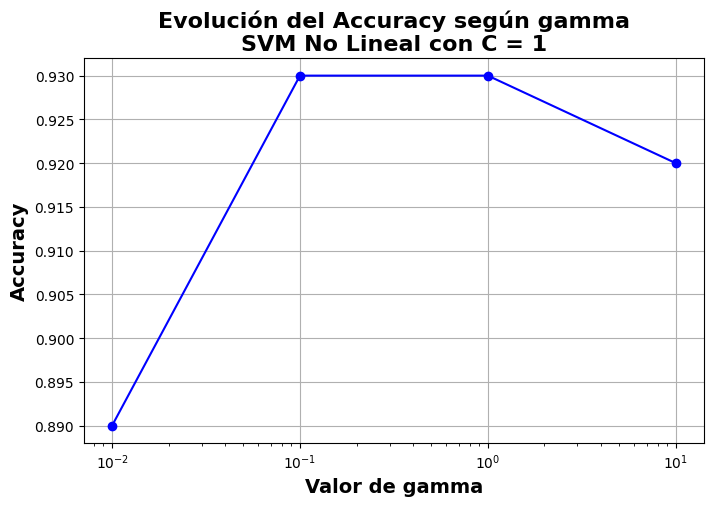

In [27]:
ver_resultados(resultados_c1, C_value)

# Aplicación de cross validation

Claramente, la experimientación anterior, es completamente manual entonces surge la pregunta: **Existe alguna forma de probar con varios valores y encontrar el mejor resultado** ❓

La respuesta: SI, usando `CrossValidation`

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros encontrados:
{'C': 10, 'gamma': 10, 'kernel': 'rbf'}

Mejor puntuación (accuracy promedio en validación cruzada):
0.8825

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        48
           1       0.98      0.83      0.90        52

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



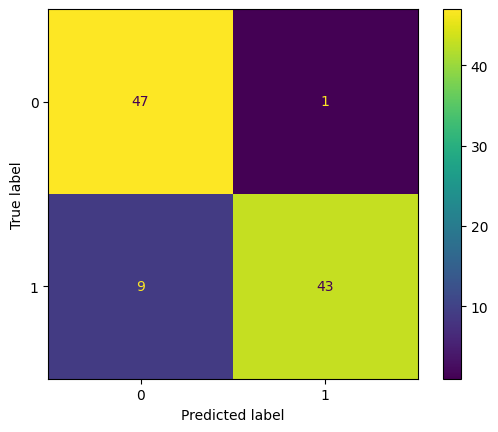

In [28]:
# Paso 1: Configurar los parámetros a explorar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Valores de C
    'gamma': [0.01, 0.1, 1, 10],  # Valores de gamma
    'kernel': ['rbf']  # Se mantiene el kernel como rbf (no lineal)
}

# Paso 2: Configurar el clasificador y el esquema de validación cruzada
svc = SVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

# Paso 3: Crear el GridSearchCV
grid_search = GridSearchCV(
    svc,
    param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=cv,
    verbose=1,
    n_jobs=-1  # Paralelizar el proceso
)

# Paso 4: Ajustar el modelo con los datos
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación (accuracy promedio en validación cruzada):")
print(grid_search.best_score_)

# Paso 5: Evaluar el mejor modelo en datos de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Reporte de métricas y matriz de confusión
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


In [29]:
# Convertir los resultados a un DataFrame para exploración
results_df = pd.DataFrame(grid_search.cv_results_)
results_df[['param_C', 'param_gamma', 'mean_test_score']]

,param_C,param_gamma,mean_test_score
0,0.1,0.01,0.7125
1,0.1,0.10,0.8425
2,0.1,1.00,0.8650
3,0.1,10.00,0.8550
4,1.0,0.01,0.8200
5,1.0,0.10,0.8575
6,1.0,1.00,0.8700
7,1.0,10.00,0.8675
8,10.0,0.01,0.8525
9,10.0,0.10,0.8625


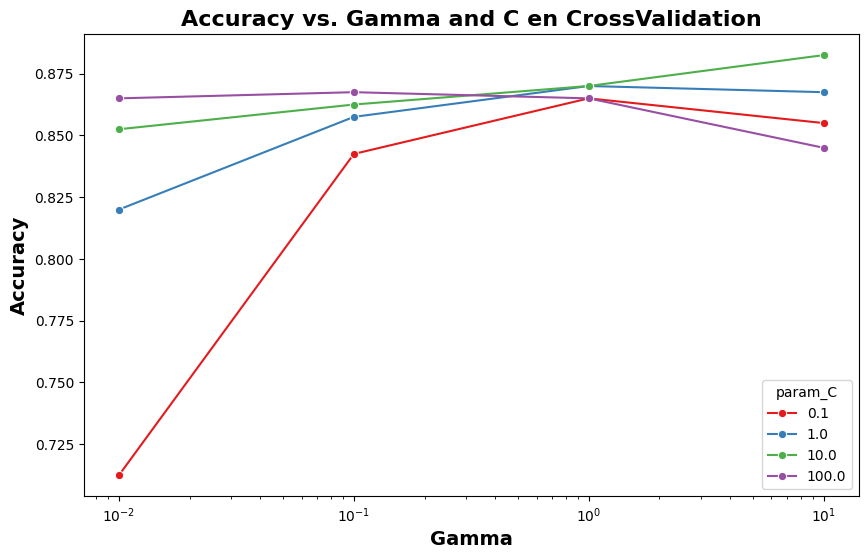

In [38]:
plt.figure(figsize=(10, 6))
sb.lineplot(x='param_gamma', y='mean_test_score', hue='param_C', data=results_df,
                palette="Set1",
                marker='o')
plt.title('Accuracy vs. Gamma and C en CrossValidation', fontsize=16, fontweight="bold")
plt.xlabel('Gamma', fontsize=14, fontweight="bold")
plt.ylabel('Accuracy', fontsize=14, fontweight="bold")
plt.xscale('log')